# GNN Link Prediction — Model Evaluation

Evaluate the knowledge-graph GNN for **(Pralsetinib, inhibits, Protein)** link prediction with a **train/test split** on known off-target edges. Report test-set metrics (Recall@k, MRR, rank stats) and visualizations.

In [1]:
import sys
from pathlib import Path
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

_cwd = Path(".").resolve()
if (_cwd / "data" / "kg_nodes_final.csv").exists():
    PROJECT_ROOT = _cwd
else:
    PROJECT_ROOT = _cwd.parent
SCRIPT_DIR = PROJECT_ROOT / "scripts" / "modeling" / "gnn"
BASELINE_SCRIPT_DIR = PROJECT_ROOT / "scripts" / "modeling" / "baseline"
if str(SCRIPT_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPT_DIR))
if str(BASELINE_SCRIPT_DIR) not in sys.path:
    sys.path.insert(0, str(BASELINE_SCRIPT_DIR))

from kg_gnn_data import (
    get_positive_and_candidate_tails,
    load_kg_graph,
    negative_sampling,
)
from kg_gnn_model import GCNLinkPredictor
from kg_baseline_link_prediction import compute_baseline_scores

plt.rcParams["figure.dpi"] = 120
plt.rcParams["font.size"] = 11
sns.set_theme(style="whitegrid", palette="husl")
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

c:\Users\suchi\anaconda3\envs\venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 1. Load data and train/test split

Load the KG and split known **(Pralsetinib, inhibits, Protein)** edges into train (80%) and test (20%) for evaluation.

In [2]:
DATA_DIR = PROJECT_ROOT / "data"
nodes_path = DATA_DIR / "kg_nodes_final.csv"
edges_path = DATA_DIR / "kg_edges_final.csv"
assert nodes_path.exists() and edges_path.exists(), "Run from repo with data/kg_nodes_final.csv and data/kg_edges_final.csv"

# Load ontology-grounded graph (final)
data, id_to_idx = load_kg_graph(nodes_path, edges_path)
idx_to_id = {v: k for k, v in id_to_idx.items()}

positive_tails, candidate_tails, drug_idx = get_positive_and_candidate_tails(
    edges_path, id_to_idx, nodes_path
)
n_pos = len(positive_tails)
assert n_pos > 0, "No positive (Pralsetinib, inhibits, protein) edges found."

# Train/test split by protein ID: hold out 5 edges for test (reuse same split for ungrounded graph)
positive_tail_ids = [idx_to_id[i] for i in positive_tails]
n_test = min(5, n_pos)
random.shuffle(positive_tail_ids)
test_ids = positive_tail_ids[:n_test]
train_ids = positive_tail_ids[n_test:]
train_pos = [id_to_idx[pid] for pid in train_ids]
test_pos = [id_to_idx[pid] for pid in test_ids]

print(f"Known positives: {n_pos}")
print(f"Train: {len(train_pos)}  |  Test (held-out): {len(test_pos)}")
print(f"Candidate proteins (ranking pool): {len(candidate_tails)}")

Known positives: 13
Train: 8  |  Test (held-out): 5
Candidate proteins (ranking pool): 516


## 2. Train GNN on training set only

Negative sampling uses only non-positive candidates. Test positives are never used in the loss.

In [3]:
neg_pairs = negative_sampling(
    drug_idx, train_pos, candidate_tails,
    num_negatives_per_positive=5, seed=SEED,
)
neg_tail_indices = [p[1] for p in neg_pairs]
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_gpu = data.to(device)
in_channels = data_gpu.x.size(1)
model = GCNLinkPredictor(
    in_channels=in_channels, hidden_channels=64, out_channels=32,
    num_layers=2, dropout=0.5,
).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)

pos_tensor = torch.tensor(train_pos, dtype=torch.long, device=device)
neg_tensor = torch.tensor(neg_tail_indices, dtype=torch.long, device=device)

epochs = 200
train_losses = []
model.train()
for epoch in range(epochs):
    optimizer.zero_grad()
    h = model(data_gpu)
    loss = model.loss_batch(h, drug_idx, pos_tensor, neg_tensor)
    loss.backward()
    optimizer.step()
    train_losses.append(loss.item())
    if (epoch + 1) % 50 == 0 or epoch == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch+1}/{epochs}, loss = {loss.item():.4f}")
print("Training done.")

Epoch 1/200, loss = 0.7198
Epoch 50/200, loss = 0.0485
Epoch 100/200, loss = 0.0638
Epoch 150/200, loss = 0.0527
Epoch 200/200, loss = 0.0152
Training done.


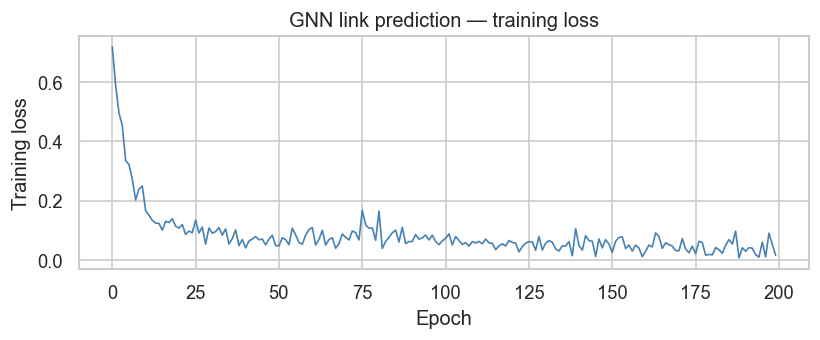

In [4]:
plt.figure(figsize=(7, 3))
plt.plot(train_losses, color="steelblue", linewidth=1)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.title("GNN link prediction — training loss")
plt.tight_layout()
plt.show()

## 3. Evaluate on held-out test set

Score all candidate proteins and compute where held-out positives rank. Then compute **Recall@k**, **MRR**, and rank statistics.

In [5]:
model.eval()
with torch.no_grad():
    h = model(data_gpu)
    cand_tensor = torch.tensor(candidate_tails, dtype=torch.long, device=device)
    scores = model.predict_link(h, drug_idx, cand_tensor)
    scores_np = scores.cpu().numpy()

# Rank order (descending score)
order = scores_np.argsort()[::-1]
test_set = set(test_pos)

pos_to_rank = {}
for rank_1based, idx in enumerate(order, start=1):
    tail_idx = candidate_tails[idx]
    if tail_idx in test_set and tail_idx not in pos_to_rank:
        pos_to_rank[tail_idx] = rank_1based
    if len(pos_to_rank) == len(test_set):
        break

n_candidates = len(candidate_tails)
ranks = [pos_to_rank.get(p, n_candidates + 1) for p in test_pos]

# Recall@k
k_list = [5, 10, 20, 50]
recall_at_k = {}
for k in k_list:
    recall_at_k[k] = sum(1 for r in ranks if r <= k) / len(test_pos) if test_pos else 0.0

# MRR and rank stats
mrr = np.mean([1.0 / r for r in ranks]) if ranks else 0.0
mean_rank = np.mean(ranks)
median_rank = np.median(ranks)

metrics_summary = {
    "Recall@5": recall_at_k[5],
    "Recall@10": recall_at_k[10],
    "Recall@20": recall_at_k[20],
    "Recall@50": recall_at_k[50],
    "MRR": mrr,
    "Mean rank": mean_rank,
    "Median rank": median_rank,
}
print("Test set metrics (GNN):")
for name, val in metrics_summary.items():
    if "Recall" in name or "MRR" in name:
        print(f"  {name}: {val:.3f}")
    else:
        print(f"  {name}: {val:.1f}")
# Store for comparison with baseline
metrics_gnn = dict(metrics_summary)
recall_at_k_gnn = dict(recall_at_k)
ranks_gnn = list(ranks)

Test set metrics (GNN):
  Recall@5: 0.200
  Recall@10: 0.600
  Recall@20: 1.000
  Recall@50: 1.000
  MRR: 0.140
  Mean rank: 10.6
  Median rank: 10.0


In [6]:
# Summary table for reporting
metrics_df = pd.DataFrame([metrics_summary]).T.rename(columns={0: "Value"})
metrics_df

,Value
Recall@5,0.200000
Recall@10,0.600000
Recall@20,1.000000
Recall@50,1.000000
MRR,0.139503
Mean rank,10.600000
Median rank,10.000000


## 4. Baseline (no GNN) and comparison

Compute the same metrics for the simple KG baseline (sum of edge weights per protein). Compare GNN vs baseline on the same held-out test set.

In [7]:
# Baseline: rank candidates by sum of (drug, inhibits, protein) edge weights
baseline_rows = compute_baseline_scores(nodes_path, edges_path)
baseline_sorted = sorted(baseline_rows, key=lambda r: (-float(r["score"]), str(r["protein_id"])))
protein_to_rank_baseline = {str(r["protein_id"]): i + 1 for i, r in enumerate(baseline_sorted)}
n_cand_baseline = len(baseline_sorted)
ranks_baseline = [protein_to_rank_baseline.get(pid, n_cand_baseline + 1) for pid in test_ids]

recall_at_k_baseline = {}
for k in k_list:
    recall_at_k_baseline[k] = sum(1 for r in ranks_baseline if r <= k) / len(test_ids) if test_ids else 0.0
mrr_baseline = np.mean([1.0 / r for r in ranks_baseline]) if ranks_baseline else 0.0
metrics_baseline = {
    "Recall@5": recall_at_k_baseline[5],
    "Recall@10": recall_at_k_baseline[10],
    "Recall@20": recall_at_k_baseline[20],
    "Recall@50": recall_at_k_baseline[50],
    "MRR": mrr_baseline,
    "Mean rank": np.mean(ranks_baseline),
    "Median rank": np.median(ranks_baseline),
}
print("Test set metrics (baseline, no GNN):")
for name, val in metrics_baseline.items():
    if "Recall" in name or "MRR" in name:
        print(f"  {name}: {val:.3f}")
    else:
        print(f"  {name}: {val:.1f}")

Test set metrics (baseline, no GNN):
  Recall@5: 0.200
  Recall@10: 0.400
  Recall@20: 0.400
  Recall@50: 0.400
  MRR: 0.238
  Mean rank: 142.6
  Median rank: 70.0


In [8]:
# Comparison table: GNN vs Baseline
compare_df = pd.DataFrame({"GNN": metrics_gnn, "Baseline (no GNN)": metrics_baseline})
compare_df

,GNN,Baseline (no GNN)
Recall@5,0.200000,0.200000
Recall@10,0.600000,0.400000
Recall@20,1.000000,0.400000
Recall@50,1.000000,0.400000
MRR,0.139503,0.237507
Mean rank,10.600000,142.600000
Median rank,10.000000,70.000000


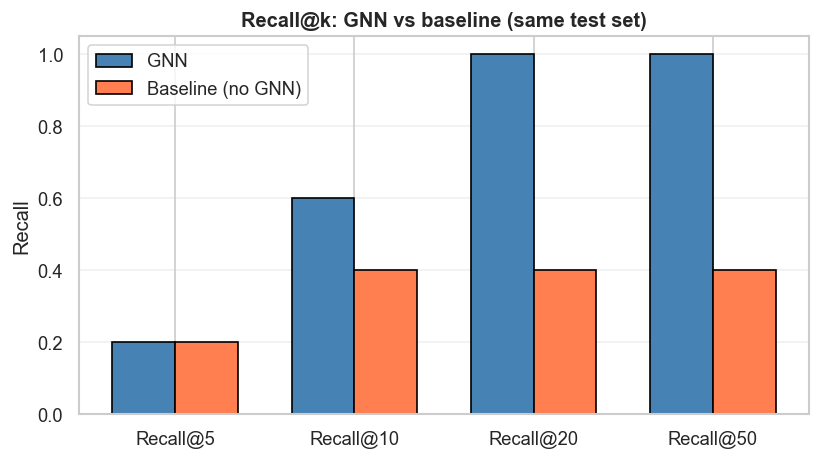

In [9]:
# Recall@k comparison: GNN vs Baseline
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(len(k_list))
width = 0.35
ax.bar(x - width/2, [recall_at_k_gnn[k] for k in k_list], width, label="GNN", color="steelblue", edgecolor="black")
ax.bar(x + width/2, [recall_at_k_baseline[k] for k in k_list], width, label="Baseline (no GNN)", color="coral", edgecolor="black")
ax.set_xticks(x)
ax.set_xticklabels([f"Recall@{k}" for k in k_list])
ax.set_ylabel("Recall")
ax.set_ylim(0, 1.05)
ax.set_title("Recall@k: GNN vs baseline (same test set)", fontweight="bold")
ax.legend()
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

## 5. Visualizations

**Left:** Recall@k on the held-out test set. **Right:** Distribution of test positives by rank bucket.

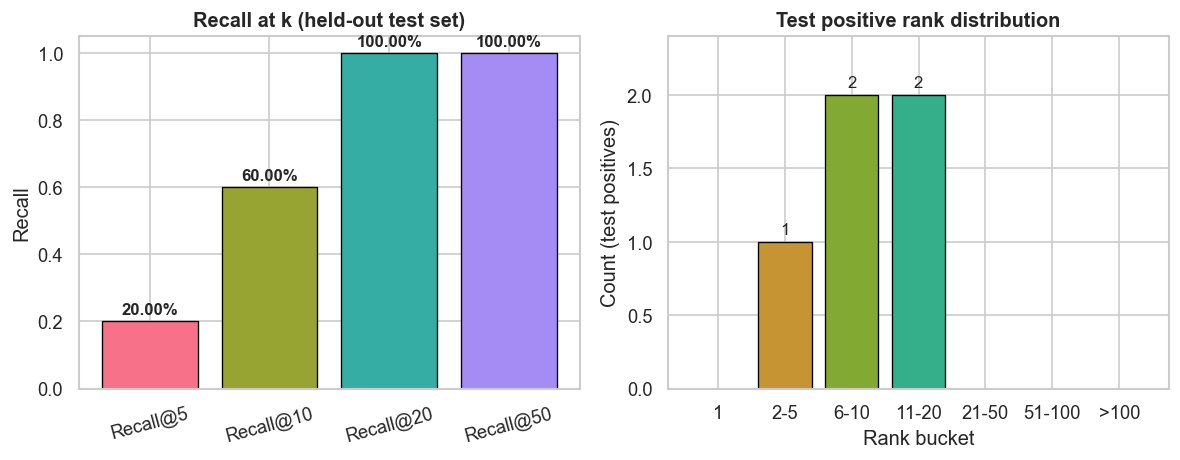

In [10]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

# Recall@k bar chart
ax1 = axes[0]
x = [f"Recall@{k}" for k in k_list]
y = [recall_at_k[k] for k in k_list]
bars = ax1.bar(x, y, color=sns.color_palette("husl", len(k_list)), edgecolor="black", linewidth=0.8)
ax1.set_ylabel("Recall")
ax1.set_ylim(0, 1.05)
ax1.set_title("Recall at k (held-out test set)", fontsize=12, fontweight="bold")
for b, v in zip(bars, y):
    ax1.text(b.get_x() + b.get_width()/2, b.get_height() + 0.02, f"{v:.2%}", ha="center", fontsize=10, fontweight="bold")
ax1.tick_params(axis="x", rotation=15)

# Rank distribution (test positives)
ax2 = axes[1]
def bucket_rank(r):
    if r <= 1: return 0
    if r <= 5: return 1
    if r <= 10: return 2
    if r <= 20: return 3
    if r <= 50: return 4
    if r <= 100: return 5
    return 6
rank_labels = ["1", "2-5", "6-10", "11-20", "21-50", "51-100", ">100"]
counts = [sum(1 for r in ranks if bucket_rank(r) == i) for i in range(7)]
colors = sns.color_palette("husl", len(rank_labels))
bars2 = ax2.bar(rank_labels, counts, color=colors, edgecolor="black", linewidth=0.8)
ax2.set_xlabel("Rank bucket")
ax2.set_ylabel("Count (test positives)")
ax2.set_title("Test positive rank distribution", fontsize=12, fontweight="bold")
for b, v in zip(bars2, counts):
    if v > 0:
        ax2.text(b.get_x() + b.get_width()/2, b.get_height() + 0.05, str(int(v)), ha="center", fontsize=10)
ax2.set_ylim(0, max(counts) * 1.2 if counts else 1)
plt.tight_layout()
plt.show()